In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# import os
# os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [2]:
train_dir = "dataset/train"
valid_dir = "dataset/validation"
test_dir = "dataset/test"
num_classes = 10

In [3]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

test_datagen = ImageDataGenerator(
    rescale=1./255
)

validation_datagen = ImageDataGenerator(
    rescale=1./255
)

2023-09-06 21:26:15.569624: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [4]:
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode="categorical"
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode="categorical",
    shuffle=False
)

validation_generator = validation_datagen.flow_from_directory(
    valid_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode="categorical"
)

Found 837 images belonging to 10 classes.


Found 99 images belonging to 10 classes.
Found 97 images belonging to 10 classes.


In [5]:
# 架构mobilenet预训练模型，基于imagenet的训练数据，不包括输出层参数

from tensorflow.keras.applications import MobileNetV2

base_model = MobileNetV2(weights="imagenet", include_top=False, input_shape=(224, 224, 3))

# 对base模型参数不可调整
for layer in base_model.layers:
    layer.trainable = False

2023-09-06 21:26:18.325484: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [6]:
base_model.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                              

In [7]:
# 定义我们自己的输出层

from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model

x = base_model.output
x = GlobalAveragePooling2D()(x)  #每个feature map取平均，生成特征向量
x = Dense(1024, activation="relu")(x) #1024全连接层
predictions = Dense(num_classes, activation="softmax")(x) #10分类的概率分布

model = Model(inputs=base_model.input, outputs=predictions)

In [8]:
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

In [9]:
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size,
    epochs=10
)

Epoch 1/10


2023-09-06 21:26:21.852606: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


 3/26 [==>...........................] - ETA: 2:24 - loss: 2.6551 - accuracy: 0.1594

/home/zhfall/miniconda3/envs/tf/lib/python3.11/site-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


26/26 [==============================] - ETA: 0s - loss: 1.5663 - accuracy: 0.5155

2023-09-06 21:28:42.666177: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


26/26 [==============================] - 157s 6s/step - loss: 1.5663 - accuracy: 0.5155 - val_loss: 0.6703 - val_accuracy: 0.8646
Epoch 2/10
26/26 [==============================] - 152s 6s/step - loss: 0.5693 - accuracy: 0.8559 - val_loss: 0.2906 - val_accuracy: 0.9479
Epoch 3/10
26/26 [==============================] - 149s 6s/step - loss: 0.3555 - accuracy: 0.9155 - val_loss: 0.2301 - val_accuracy: 0.9479
Epoch 4/10
26/26 [==============================] - 152s 6s/step - loss: 0.2750 - accuracy: 0.9354 - val_loss: 0.1791 - val_accuracy: 0.9583
Epoch 5/10
26/26 [==============================] - 162s 6s/step - loss: 0.2213 - accuracy: 0.9491 - val_loss: 0.1975 - val_accuracy: 0.9479
Epoch 6/10
26/26 [==============================] - 151s 6s/step - loss: 0.1878 - accuracy: 0.9578 - val_loss: 0.1733 - val_accuracy: 0.9479
Epoch 7/10
26/26 [==============================] - 149s 6s/step - loss: 0.1627 - accuracy: 0.9627 - val_loss: 0.1736 - val_accuracy: 0.9583
Epoch 8/10
26/26 [======

In [10]:
history_df = pd.DataFrame(history.history)
history_df

,loss,accuracy,val_loss,val_accuracy
0,1.566290,0.515528,0.670259,0.864583
1,0.569262,0.855901,0.290607,0.947917
2,0.355486,0.915528,0.230144,0.947917
3,0.275018,0.935404,0.179114,0.958333
4,0.221311,0.949068,0.197479,0.947917
5,0.187802,0.957764,0.173330,0.947917
6,0.162676,0.962733,0.173635,0.958333
7,0.140424,0.978882,0.135643,0.968750
8,0.126696,0.973913,0.162791,0.958333
9,0.115356,0.981366,0.152813,0.958333


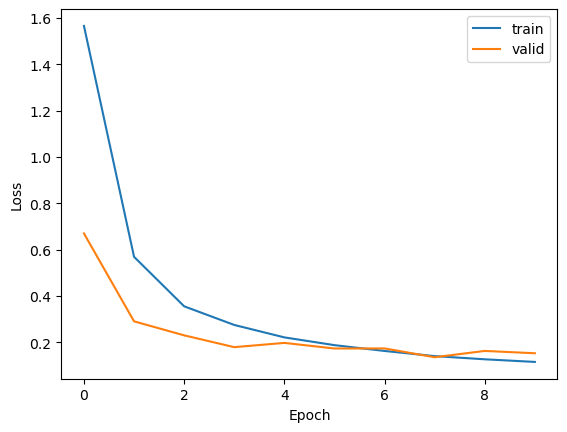

In [11]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(["train", "valid"])
plt.show()

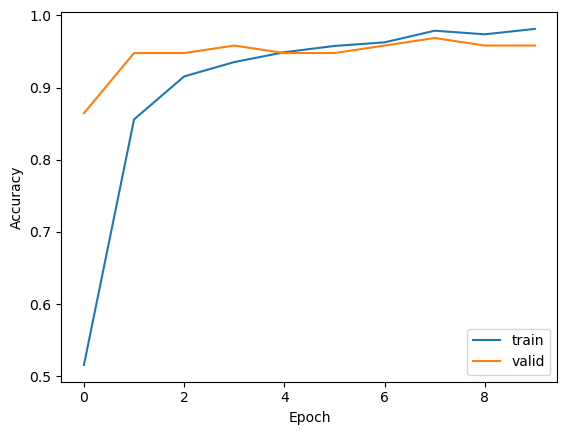

In [12]:
plt.figure()
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend(["train", "valid"])
plt.show()

In [13]:
preds = model.predict(test_generator)

2023-09-06 21:55:18.070138: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


4/4 [==============================] - 19s 4s/step


In [14]:
y_pred = np.argmax(preds, axis=1)

In [15]:
for k, v in test_generator.class_indices.items():
    print(v, ":", k)

0 : apple
1 : banana
2 : grapes
3 : kiwi
4 : mango
5 : orange
6 : pear
7 : pineapple
8 : pomegranate
9 : watermelon


In [16]:
pred_classes = {
    0 : "apple",
    1 : "banana",
    2 : "grapes",
    3 : "kiwi",
    4 : "mango",
    5 : "orange",
    6 : "pear",
    7 : "pineapple",
    8 : "pomegranate",
    9 : "watermelon"
}

In [17]:
y_pred = list(map(lambda x: pred_classes[x], y_pred))

In [18]:
y_test = list(map(lambda x: pred_classes[x], test_generator.classes))

In [19]:
from sklearn.metrics import classification_report

print(classification_report(y_pred, y_test))

              precision    recall  f1-score   support

       apple       0.80      0.89      0.84         9
      banana       0.78      0.88      0.82         8
      grapes       1.00      1.00      1.00        10
        kiwi       1.00      1.00      1.00        10
       mango       1.00      0.91      0.95        11
      orange       1.00      1.00      1.00        10
        pear       1.00      0.91      0.95        11
   pineapple       1.00      1.00      1.00        10
 pomegranate       1.00      1.00      1.00        10
  watermelon       1.00      1.00      1.00        10

    accuracy                           0.96        99
   macro avg       0.96      0.96      0.96        99
weighted avg       0.96      0.96      0.96        99



In [20]:
model.save("mv3.h5")